# Chest X-ray diagnosis

## Problem Statement
We will build a range of neural networks to diagnose chest X-rays, where our database consists of patients suffering from COVID-19, Pneumonia, and normal healthy patients (3 classes).

## Initialize the notebook
We will start by connecting google drive to our notebook, we will need it to load kaggle config and download our dataset into.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Next, we will load our config file to be able to use kaggle's api.

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
# changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
#Check the present working directory using pwd command
%pwd

'/content/gdrive/My Drive/Kaggle'

## Download the dataset from kaggle

We will then check if we already downloaded our data set, if not we will download the dataset .zip file, unzip it and remove the .zip file.<br>

We are doing so in order to not download our dataset for each notebook run, and to be able to run this notebook anywhere.

In [ ]:
from pathlib import Path

# we will add the dataset url here, this is the only part that requires changing
# the rest of the code will handle the rest
dataset_url = "tawsifurrahman/covid19-radiography-database"

# find the name of the dataset
dataset_dir = dataset_url.split("/")[1]

# check the default directory for the dataset
my_file = Path("/content/gdrive/My Drive/Kaggle/" + dataset_dir)
print(my_file)

if not my_file.is_dir():
    # directory doesn't exist
    !kaggle datasets download -d "$dataset_url"
    
    # unzipping the zip files and deleting the zip files
    ! unzip "$dataset_dir".zip -d "$dataset_dir"

    # remove the .zip file
    !rm "$dataset_dir".zip

    print("Dataset downloaded")

else:
    print("Dataset already downloaded.")

/content/gdrive/My Drive/Kaggle/covid19-radiography-database
Dataset already downloaded.


## Imports

We will be running 13 models,so we are going to use a gpu as it is much faster, but since there is a time limit on how much you can use the gpu on colab, the code will keep running even if you aren't using a gpu, if you want to stop the execution of the notebook if gpu not found, uncomment the line "raise SystemError('GPU device not found')".

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print("GPU not used")
  # raise SystemError('GPU device not found')
  
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# check tensorflow version
print("tensorflow version: ", tf.__version__)

# to always get the same results
np.random.seed(42)

%matplotlib inline

Found GPU at: /device:GPU:0
Num GPUs Available:  1
tensorflow version:  2.4.0


## Data Collection

In [ ]:
# helper function to generate our features
def diagnosis(file_dir):
    if "normal" in file_dir.lower():
        return "normal"
    elif "pneumonia" in file_dir.lower():
        return "pneumonia"
    elif "covid" in file_dir.lower():
        return "covid"
    else:
        return ""

def load_data(parent_folder, folder):
    # the parent folder directory 
    parent_dir = "./" + parent_folder

    # load the files in the 1st folder in our directory
    files_dir = tf.io.gfile.glob(parent_dir + folder[0] + '/*')

    # if there is multibles folders, load their files as well
    for i in range(1, len(folder)): 
        files_dir.extend(tf.io.gfile.glob(parent_dir + folder[i] + '/*'))
    
    # create our DataFrame
    data_df = pd.DataFrame(files_dir, columns=["dir"])

    # create our labels column
    data_df["diagnosis"] = data_df.apply(lambda r: diagnosis(r[0]), axis=1)

    return data_df

parent_folder = dataset_dir + "/COVID-19 Radiography Database/"

# dynamic folder naming
folder = [x[0] for x in os.walk(parent_folder)]
folder = folder[1:]
folder = [x.split("/")[-1] for x in folder]

# static/hard-coded folder naming
# folder = ["COVID", "NORMAL", "Viral Pneumonia"]

data_df = load_data(parent_folder, folder)

In [ ]:
# taking a quick look at our dataset
data_df.head()

,dir,diagnosis
0,./covid19-radiography-database/COVID-19 Radiog...,covid
1,./covid19-radiography-database/COVID-19 Radiog...,covid
2,./covid19-radiography-database/COVID-19 Radiog...,covid
3,./covid19-radiography-database/COVID-19 Radiog...,covid
4,./covid19-radiography-database/COVID-19 Radiog...,covid


## Data Exploration

### Finding how many elements in each class

In [ ]:
# finding the count of each class in our dataset
counts = data_df.groupby("diagnosis").count()["dir"]

print(counts)
print()
print("total patients = ", data_df.shape[0])

diagnosis
covid        1200
normal       1341
pneumonia    1345
Name: dir, dtype: int64

total patients =  3886


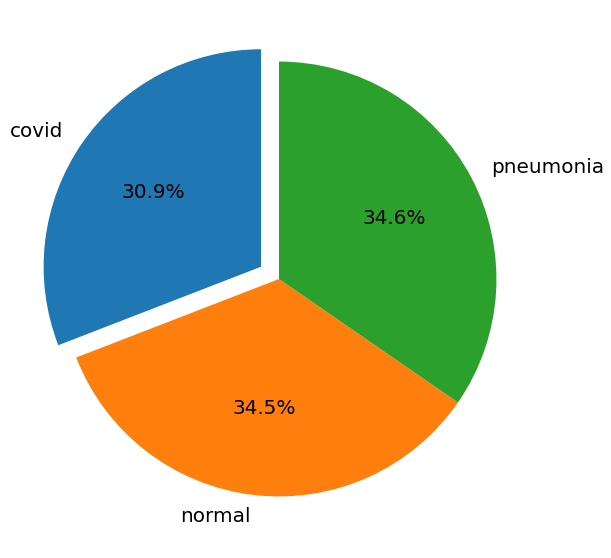

In [ ]:
plt.figure(figsize=(20,10))
explode = (0.1, 0, 0)
plt.pie(counts, explode=explode, labels=data_df["diagnosis"].unique(), autopct='%1.1f%%', 
        startangle=90, textprops={'fontsize': 20})
plt.show()

### Showing some samples and their shapes

covid image size: 331x331



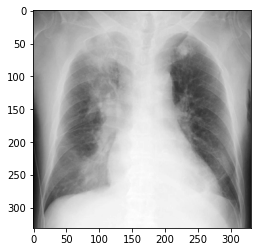

normal image size: 1024x1024



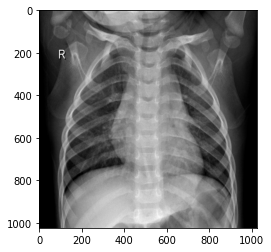

pneumonia image size: 1024x1024



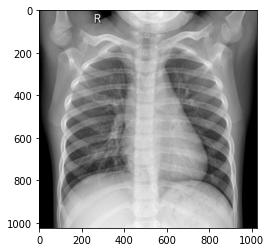

In [ ]:
# looking at an image from each class
image_index = {}
image_index["covid"] = np.random.randint(counts[0]) # add a random covid image index
image_index["normal"] = np.random.randint(counts[0], counts[1]) # add a random normal image index
image_index["pneumonia"] = np.random.randint(counts[1], counts[2]) # add a random pneumonia image index

for k, v in image_index.items():
    img = Image.open(data_df["dir"][v])
    img_h, img_w = img.height, img.width
    plt.imshow(img, cmap="gray")
    print(f"{k} image size: {img_h}x{img_w}")
    print()
    plt.show()

it appears our images come from diffirent sources and they have different sizes, by reading the README.md file, we get more insights on how and from where the data was collected. Also there is a note about the Format of the images in the data set, it says:
- All the images are in Portable Network Graphics (PNG) file format and resolution are 1024\*1024 pixels and 256\*256 pixels, which can be easily converted to 224\*224 or 227\*227 pixels typically required by the popular Convolutional Neural Networks (CNNs).

We will reshape them to 224x224 pixels in this notebook, but feel free to change it. 

### Looking at different data augmentation methods

We will also apply different augmentation methods to our images, Using a vertical flip doesn't make much sense in this data set so we will ignore it.

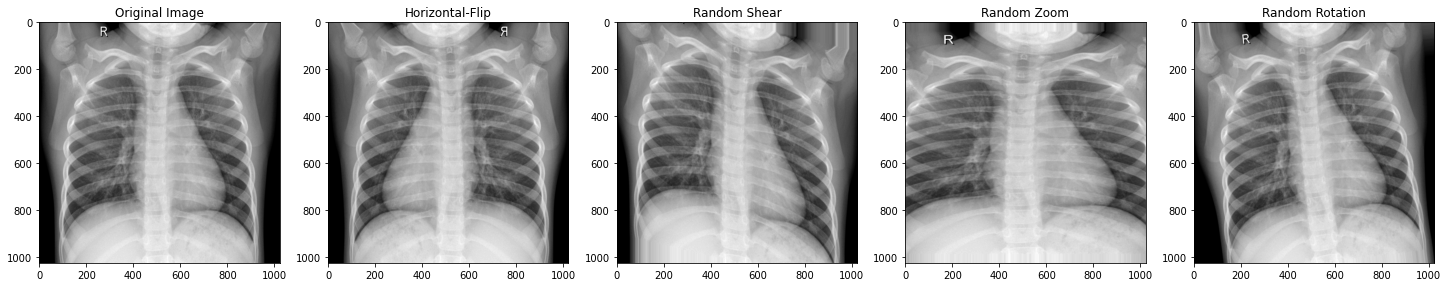

In [ ]:
array_img = tf.keras.preprocessing.image.img_to_array(img)

fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(151)
ax1.imshow(img, cmap="gray")
ax1.title.set_text('Original Image')

# Horizontal Flip
ax2 = fig.add_subplot(152)
ax2.title.set_text('Horizontal-Flip')
flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
ax2.imshow(flipped, cmap="gray")

# random shear 
ax3 = fig.add_subplot(153)
ax3.title.set_text('Random Shear')
sheared = tf.keras.preprocessing.image.random_shear(array_img, 30,
                                                    row_axis=0, col_axis=1,
                                                    channel_axis=2)
sheared = tf.keras.preprocessing.image.array_to_img(sheared)
ax3.imshow(sheared, cmap="gray")

# random zoom
ax4 = fig.add_subplot(154)
ax4.title.set_text('Random Zoom')
zoomed = tf.keras.preprocessing.image.random_zoom(array_img, (0.6, 1.4),
                                                    row_axis=0, col_axis=1,
                                                    channel_axis=2)
zoomed = tf.keras.preprocessing.image.array_to_img(zoomed)
ax4.imshow(zoomed, cmap="gray")

# random rotation
ax5 = fig.add_subplot(155)
ax5.title.set_text('Random Rotation')
rotated = tf.keras.preprocessing.image.random_rotation(array_img, 10,
                                                            row_axis=0, col_axis=1,
                                                            channel_axis=2)

rotated = tf.keras.preprocessing.image.array_to_img(rotated)
ax5.imshow(rotated, cmap="gray")

plt.show()

## Data Preprocessing

We will have to change our classes format from strings into a more understandable format for our model, so we will use a LabelEncoder() to enumerate them automatically for us.

Usually we will use OneHot encoding for multiple classes, but our custom data loader (generator) will handle this step for us, that's why the rest of the code is commented (the function is *tf.keras.utils.to_categorical* and it is used at the output of our generator labels).

In [ ]:
#Encode labels as integers
le = LabelEncoder()
data_df["diagnosis_cat"] = le.fit_transform(data_df["diagnosis"])

# # creating instance of one-hot-encoder
# enc = OneHotEncoder(handle_unknown='ignore')

# # creating a dataframe holding the one-hot encoded values
# enc_df = pd.DataFrame(enc.fit_transform(data_df[["diagnosis_cat"]]).toarray())

# # merge our main dataframe with the encoded dataframe on key values
# data_df = data_df.join(enc_df)

# let's take a look at our new dataframe
data_df.head()

,dir,diagnosis,diagnosis_cat
0,./covid19-radiography-database/COVID-19 Radiog...,covid,0
1,./covid19-radiography-database/COVID-19 Radiog...,covid,0
2,./covid19-radiography-database/COVID-19 Radiog...,covid,0
3,./covid19-radiography-database/COVID-19 Radiog...,covid,0
4,./covid19-radiography-database/COVID-19 Radiog...,covid,0


## Train-Validation-Test split

In [ ]:
data_size = data_df.shape[0]

## intial split is around 60% 20% 20%
test_size = 0.2
val_size = 0.25

train, test = train_test_split(data_df, test_size=test_size, random_state=42, stratify=data_df["diagnosis"])
train, val = train_test_split(train, test_size=val_size, random_state=42, stratify=train["diagnosis"])
print("train images count: {} ({:.1f}%)".format(train.shape[0], (train.shape[0]/data_size)*100))
print("validation images count: {} ({:.1f}%)".format(val.shape[0], (val.shape[0]/data_size)*100))
print("test images count: {} ({:.1f}%)".format(test.shape[0], (test.shape[0]/data_size)*100))

train images count: 2331 (60.0%)
validation images count: 777 (20.0%)
test images count: 778 (20.0%)


## Data Loader (Creating our data Generator)

the generator will be used for real-time data feeding to your tf.keras model. We make the latter inherit the properties of tf.keras.utils.Sequence so that we can leverage nice functionalities such as multiprocessing.

Advantages of Sequence over a regular generator:
- With **sequence**, it's possible to keep track of which batches were already taken, which batches are sent to which thread for loading, and there will never be a conflict because it's based on indices.
- With **generator**, parallel processing will lose track of what batches were already taken or not because threads don't talk to each other and there is no other option than yielding batch by batch sequentially.

Advantages of generators and sequences over a loop:
- In a **loop**, you will "wait for batch load", "wait for model training", "wait for batch load", "wait for model training".
- With **fit_generator**, batches will be loaded "while" the model is training, you have both things happening simultaneously.

For very simple generators, there won't be a big impact. For complex generators, augmentators, big image loaders, etc., the generation time is very significant and may severely impact your speed.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, labels, folder_dir='', 
                 batch_size = 16, dim=(224,224),
                 n_channels=3, n_classes=3, 
                 train=True, shuffle=True):
        
        self.list_IDs = list_IDs      # input
        self.labels = labels          # output classes
        self.folder_dir = folder_dir  # train_images folder
        self.batch_size = batch_size  # number of samples to work through before updating internal params
        self.dim = dim                # the resized dimensions
        self.n_channels = n_channels  # the number of channels (1 for grayscale or 3 for RGB)
        self.n_classes = n_classes    # number of output classes
        self.train = train            # used to apply augmentations to train/validation set
        self.shuffle = shuffle        # if True, shuffle the data after each epoch
        self.n = len(list_IDs)        # size of our input data
        self.on_epoch_end()           # np.array with indices from 0 to len(list_IDs) and shuffle them if True pointing @ list_IDs
    
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs)) / self.batch_size)
    
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # get a slice of the indecies with batch_size
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size] 
        # get a list of ImageId for the current batch
        list_IDs_temp  = [self.list_IDs[i] for i in indexes]
        labels_temp = [self.labels[i] for i in indexes]
        # generate data
        X, y = self.__data_generation(list_IDs_temp, labels_temp)
        # return data 
        return X, y
    
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
           
        
    def __data_generation(self, list_IDs_temp, labels_temp):
        'Generates data containing batch_size samples'
        # reserve memory for inputs and outputs for each batch
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        # Read Data from folder_dir
        for i, ids in enumerate(list_IDs_temp):
            file_path = os.path.join(self.folder_dir, ids)
            image = Image.open(file_path)
            
            # resize our images
            image = image.resize((self.dim[1], self.dim[0]))

            # in case we are training, apply augmentations 
            if self.train:
                # because flip doesn't have a random value to apply it
                if np.random.randint(0,2):
                    image = self.flip_image(image)
                image = self.shear_image(image, 10)
                image = self.zoom_image(image, 0.2)
                image = self.rotate_image(image, 5)

            # to change it from 2-D format into 3-D format to include the channels
            image = image.convert("RGB")

            # Normalizing our data (more info in the cell below)
            image = np.array(image) / 255.

            # add our preprocessed image and its label to our current batch
            X[i, ] = image
            y[i] = labels_temp[i]
        
        # Using tf.keras.utils.to_categorical will change the output to a onehot encoding format, 
        # ex: 2 => [0, 0, 1]
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    def flip_image(self, image):
        # Horizontal Flip
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    
    def shear_image(self, image, intensity):
        # degrees = (intensity * 180) / np.pi
        array_img = tf.keras.preprocessing.image.img_to_array(image)
        sheared = tf.keras.preprocessing.image.random_shear(array_img, intensity,
                                                            row_axis=0, col_axis=1,
                                                            channel_axis=2)
        return tf.keras.preprocessing.image.array_to_img(sheared)
    
    def zoom_image(self, image, zoom_range):
        array_img = tf.keras.preprocessing.image.img_to_array(image)
        zoomed = tf.keras.preprocessing.image.random_zoom(array_img, (1-zoom_range, 1+zoom_range),
                                                            row_axis=0, col_axis=1,
                                                            channel_axis=2)
        return tf.keras.preprocessing.image.array_to_img(zoomed)

    def rotate_image(self, image, rg):
        array_img = tf.keras.preprocessing.image.img_to_array(image)
        rotated = tf.keras.preprocessing.image.random_rotation(array_img, rg,
                                                            row_axis=0, col_axis=1,
                                                            channel_axis=2)
        return tf.keras.preprocessing.image.array_to_img(rotated)
    

**Rescale:** The reason that is done is because you need to NORMALIZE your input, since the pixel values of the image will be between 0 and 1.

And reason for normalizing the input has to do with numerical stability and convergence (technically you do not need it, but with it, the neural network has a higher chance of converging and the gradient descent/adam algorithm is way more likely to be stable and maybe faster)

In [ ]:
# initializing our generators

## for 60 20 20 split
train_generator = DataGenerator(train["dir"].tolist(), train["diagnosis_cat"].tolist())
val_generator = DataGenerator(val["dir"].tolist(), val["diagnosis_cat"].tolist())
test_generator = DataGenerator(test["dir"].tolist(), test["diagnosis_cat"].tolist(),train=False)

(16, 224, 224, 3) (16, 3)
batch size: 16
input shape: (224, 224, 3)
onput shape: 3


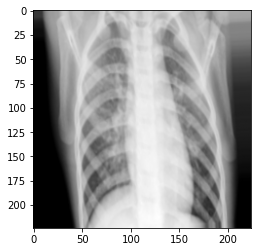

In [ ]:
# checking if our generator works

## for each x there exists 3 y (for each classId)
x, y = train_generator[0]

## check out the shapes
print(x.shape, y.shape)
print(f"batch size: {x.shape[0]}")
print(f"input shape: {x.shape[1:]}")
print(f"onput shape: {y.shape[1]}")

## showing an image from our generator
plt.imshow(x[0])
plt.show()

## Training Loop / train_step / model.fit()

We will be implementing our own training loop for this notebook, so we decided on some default parameters for the metrics, loss functions, and optimizer. But feel free to change them as you see fit.

For the **loss function**, **CategoricalCrossentropy** was used, as it is used when there are two or more label classes. We expect labels to be provided in a one_hot representation. If you want to provide labels as integers, please use **SparseCategoricalCrossentropy** loss. 

- This will provide a very low-level control over training & evaluation.
- By using **GradientTape** scope it will enable us to retrive the gradients of the trainable weights with respect to our loss value for each batch. And by using an optimizer, we can then use these gradients to update our paramters (model.trainable_weights).
- The default runtime in TensorFlow 2.0 is eager execution. Which is great for debugging, but graph compilation has a definite performance advantage. Describing your computation as a static graph enables the framework to apply global performance optimizations. This is impossible when the framework is constrained to greedly execute one operation after another, with no knowledge of what comes next.
So by using **@tf.function** decorator, we can compile into a static graph any function that takes tensors as input.
- the **earlyStopping**  method will stop the training if the models validation accuracy is not improving.

In [ ]:
def model_fit(model, train_generator, epochs, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              train_loss_fn=tf.keras.losses.CategoricalCrossentropy(name='train_loss'),
              train_acc_metric=tf.keras.metrics.CategoricalAccuracy(name='train_accuracy'),
              val_generator=None,
              val_loss_fn=tf.keras.losses.CategoricalCrossentropy(name='val_loss'),
              val_acc_metric=tf.keras.metrics.CategoricalAccuracy(name='val_accuracy'),
              n_classes=3, call_back=False,
              draw_graph=False):
    
    print()
    print(f"Fitting model ({model.name})")
    
    # compite our function as static graph to increase preformance
    @tf.function
    def train_step(x, y):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            y_pred = model(x, training=True)

            # Compute the loss value for this minibatch.
            loss_value = train_loss_fn(y, y_pred)    

            # # Add any extra losses created during the forward pass.
            # loss_value += sum(model.losses)

        # Automatically retrieve gradients
        grads = tape.gradient(loss_value, model.trainable_weights)

        # run one step of our optimizer (in our case ADAM)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metrics.
        train_acc_metric.update_state(y, y_pred)
        recall_metric.update_state(y, y_pred)
        precision_metric.update_state(y, y_pred)
        f1score_metric.update_state(y, y_pred)
        return loss_value

    # compite our function as static graph to increase preformance
    @tf.function
    def val_step(x, y):
        # Run the forward pass.
        y_pred = model(x, training=False)
         # Compute the loss value for this minibatch.
        loss_value = val_loss_fn(y, y_pred)
        # Update validation metric.
        val_acc_metric.update_state(y, y_pred)
        return loss_value

    def earlyStopping(LossList, min_delta=1e-4, patience=5):
        #No early stopping for 2*patience epochs 
        if len(LossList)//patience < 2 :
            return False
        #Mean loss for last patience epochs and second-last patience epochs
        mean_previous = np.mean(LossList[::-1][patience:2*patience]) #second-to-last
        mean_recent = np.mean(LossList[::-1][:patience]) #last
        delta_abs = np.abs(mean_recent - mean_previous) #abs change
        delta_abs = np.abs(delta_abs / mean_previous)  # relative change
        if delta_abs < min_delta :
            print("*CB_ES* Loss didn't change much from last %d epochs"%(patience))
            print("*CB_ES* Percent change in loss value:", delta_abs*1e2)
            return True
        else:
            return False

    # get the batch size
    batch_size = train_generator.batch_size

    # initializing our metrics
    accuracy_train = [0]    # created as list to be able to graph it
    accuracy_validate = [0] # created as list to be able to graph it

    recall_metric = tf.keras.metrics.Recall()
    precision_metric = tf.keras.metrics.Precision()
    f1score_metric = tfa.metrics.F1Score(num_classes=n_classes, average='weighted')

    # Iterate over epochs
    for epoch in range(epochs):
        print("\nEpoch %d" % (epoch+1,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for  step, (x_batch_train, y_batch_train) in enumerate(train_generator):
            # Log every batch.
            print("\r", f"t: {step+1}/{(train_generator.n // batch_size)}", end="", sep="")
            train_loss_value = train_step(x_batch_train, y_batch_train)

        print()

        # Run a validation loop
        if val_generator:
            val_loss_seq = []
            # Run a validation loop at the end of each epoch.
            for step, (x_batch_val, y_batch_val) in enumerate(val_generator):
                # Log every batch.
                print("\r", f"v: {step+1}/{(val_generator.n // batch_size)}", end="", sep="")
                val_loss_value = val_step(x_batch_val, y_batch_val)
                val_loss_seq.append(val_loss_value)
            print()

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        accuracy_train.append(train_acc)

        recall = recall_metric.result()
        precision = precision_metric.result()
        f1score = f1score_metric.result()

        if val_generator: 
            val_acc = val_acc_metric.result()
            accuracy_validate.append(val_acc)

        print("Loss: {:.3f} - accuracy: {:.3f}".format(train_loss_value, train_acc), end="", sep="")

        if val_generator: 
            print(" - val_loss: {:.3f} - val_accuracy: {:.3f}".format(val_loss_value, val_acc))
        else:
            print()

        # Reseting metrics at the end of each epoch
        train_acc_metric.reset_states()
        recall_metric.reset_states()
        precision_metric.reset_states()
        f1score_metric.reset_states()

        if val_generator:
            val_acc_metric.reset_states()
        
        # stop the training if the model is not improving
        if call_back:
            stopEarly = earlyStopping(val_loss_seq, min_delta=0.01, patience=2)
            if stopEarly:
                print("Early Stopping at epoch= %d/%d"%(epoch+1, epochs))
                print("Total Time taken: %.2fs" % (time.time() - start_time))
                break
        print("Total Time taken: %.2fs" % (time.time() - start_time))
        
    if draw_graph:
        plt.plot(accuracy_train)
        plt.plot(accuracy_validate)
        plt.ylabel('accuracy')
        plt.xlabel('iterations (total {} epochs)'.format(epochs))
        plt.legend(['train', 'validation'])
        plt.show()




    return model, accuracy_train[-1], accuracy_validate[-1], recall, precision, f1score

In [ ]:
def model_evaluate(model, test_generator, 
                  test_loss_fn=tf.keras.losses.CategoricalCrossentropy(name='test_loss'),
                  test_acc_metric=tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')):
    print()
    print("--------------------------------")
    print(f"Evaluating model ({model.name})")
    print()

    # compite our function as static graph to increase preformance
    @tf.function
    def test_step(x, y):
        # Run the forward pass.
        y_pred = model(x, training=False)
        # Compute the loss value for this minibatch.
        loss_value = test_loss_fn(y, y_pred)
        # Update testing metric.
        test_acc_metric.update_state(y, y_pred)
        return loss_value

    start_time = time.time()
    batch_size = test_generator.batch_size

    # Iterate over the batches of the test aset.
    for step, (x_batch_test, y_batch_test) in enumerate(test_generator):
        # Log every batch.
        print("\r", f"{step+1}/{(test_generator.n // batch_size)}", end="", sep="")
        test_loss_value = test_step(x_batch_test, y_batch_test)

    print()

    # Display metrics at the end.
    test_acc = test_acc_metric.result()
    print("accuracy: {:.3f}".format(test_acc))
    print("\nTotal Time taken: %.2fs" % (time.time() - start_time))
    return test_acc

A note on the “training=True” and “training=False” parameters: This changes how some layers behave. For instance, dropout layers drop some connections during training, but not during testing. This does not affect the optimization directly or any other training-related task

## Models

In [ ]:
# initializing models parameters
n_classes = 3
input_shape = (224, 224, 3)

### FC models


In [ ]:
def shallow_fc(input_shape = (224, 224, 3), n_classes = 3, name="Shallow-FullyConnected"):
    # 2 layers FCNN
    inputs = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Flatten()(inputs) # Layer 0
    x = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x) # Layer 1
    outputs = tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)(x) # Output Layer
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs], name=name)
    return model

def deep_fc(input_shape = (224, 224, 3), n_classes = 3, name="Deep-FullyConnected"):
    # 10 layers FCNN
    inputs = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Flatten()(inputs) # Layer 0
    x = tf.keras.layers.Dense(32, activation=tf.nn.relu)(x) # Layer 1
    x = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x) # Layer 2
    x = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x) # Layer 3
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x) # Layer 4
    x = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x) # Layer 5
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x) # Layer 6
    x = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x) # Layer 7
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation=tf.nn.relu)(x) # Layer 8
    x = tf.keras.layers.Dense(16, activation=tf.nn.relu)(x) # Layer 9
    outputs = tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)(x) # Output Layer
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs], name=name)
    return model

In [ ]:
s_fc = shallow_fc(input_shape=input_shape, n_classes=n_classes)
s_fc.summary()

Model: "Shallow-FullyConnected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 19,268,099
Trainable params: 19,268,099
Non-trainable params: 0
_________________________________________________________________


In [ ]:
d_fc = deep_fc(input_shape=input_shape, n_classes=n_classes)
d_fc.summary()

Model: "Deep-FullyConnected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4816928   
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)       

### CNN models

In [ ]:
def shallow_cnn(input_shape = (224, 224, 3), n_classes = 3, name="Shallow-CNN"):
    # 3 layers CNN
    inputs = tf.keras.layers.Input(input_shape)

    # Layer 1
    x = tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu)(inputs) 
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Layer 2
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Output Layer
    outputs = tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)(x)
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs], name=name)
    return model


def deep_cnn(input_shape = (224, 224, 3), n_classes = 3, name="Deep-CNN"):
    # 8 layers CNN
    inputs = tf.keras.layers.Input(input_shape)

    # Layer 1
    x = tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu)(inputs) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Layer 2
    x = tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Layer 3
    x = tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 4
    x = tf.keras.layers.Conv2D(128, (3,3), activation=tf.nn.relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Layer 5
    x = tf.keras.layers.Conv2D(256, (3,3), activation=tf.nn.relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Layer 6
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Layer 7
    x = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)

    # Output Layer
    outputs = tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)(x) # Output Layer
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs], name=name)
    return model

In [ ]:
s_cnn = shallow_cnn(input_shape=input_shape, n_classes=n_classes)
s_cnn.summary()

Model: "Shallow-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 197136)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                6308384   
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                

In [ ]:
d_cnn = deep_cnn(input_shape=input_shape, n_classes=n_classes)
d_cnn.summary()

Model: "Deep-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0  

#### Difference between FC and CNN



In image classification task, convolution blocks are usually flattened and then few layers of fully connected network end up to give classification results. But the retained spatial information got lost. In the case of classification, the convolution operation is done to reduce the numbers of features to be fed to a dense fully connected network. Another way to say this is Convolution operation downsamples a 2D data like image. But as mentioned above spatial information can be used to get more insights, which we are loosing by FC layer.

So, did convolution imporve our results ? <br>
**short answer** is yes. <br>
**long answer:**
The only difference between FC and CONV layers is that the neurons in the CONV layer are connected only to a local region in the input and that many of the neurons in a CONV volume share parameters. However, the neurons in both layers still compute dot products, so their functional form is identical. But despite that, Fully connected neural networks aren't good for feature extraction while CNNs are trained to identify and extract the best features from the images.

### ResNet 18

- The number after ResNet implies a certain number of neural network layers.
- They can be viewed as algorithms with a state passed from one ResNet module to another one.
- One of the problems ResNets solve is the famous known vanishing gradient. This is because when the network is too deep, the gradients from where the loss function is calculated easily shrink to zero after several applications of the chain rule. This result on the weights never updating its values and therefore, no learning is being performed.With ResNets, the gradients can flow directly through the skip connections backwards from later layers to initial filters.

In [ ]:
# download the model architecture
! pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-971l70d1
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-971l70d1
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 3.4MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20030 sha256=bd95196261fd5586b94820870595b931820659c11ede2996cdfc28d71b72b0a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ytcigzo/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [ ]:
# for tensorflow.keras
from classification_models.tfkeras import Classifiers

# Not pretrained model
ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18(input_shape=input_shape, weights=None, include_top=False)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
resnet_18 = keras.models.Model(inputs=[base_model.input], outputs=[output], name="resnet18")

# pretrained model
base_model = ResNet18(input_shape=input_shape, weights='imagenet', include_top=False)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
resnet_18_pretrained = keras.models.Model(inputs=[base_model.input], outputs=[output], name="resnet18_pretrained")

44924928/44920640 [==============================] - 1s 0us/step


### ResNet 50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

# no pretrained weights
base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(n_classes, activation= 'softmax')(x)
resnet_50 = keras.models.Model(inputs = base_model.input, outputs = predictions, name="resnet50")

# pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(n_classes, activation= 'softmax')(x)
resnet_50_pretrained = keras.models.Model(inputs = base_model.input, outputs = predictions, name="resnet50_pretrained")

94773248/94765736 [==============================] - 1s 0us/step


### DenseNet 121

- since concatenation is used. Each layer is receiving a “collective knowledge” from all preceding layers.

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121

# no pretrained weights
base_model = DenseNet121(weights=None, include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(n_classes, activation= 'softmax')(x)
densenet_121 = keras.models.Model(inputs = base_model.input, outputs = predictions, name="densenet121")

# pretrained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(n_classes, activation= 'softmax')(x)
densenet_121_pretrained = keras.models.Model(inputs = base_model.input, outputs = predictions, name="densenet121_pretrained")

29089792/29084464 [==============================] - 0s 0us/step


### Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# no pretrained weights
base_model = InceptionV3(weights=None, include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(n_classes, activation= 'softmax')(x)
inception_v3 = keras.models.Model(inputs = base_model.input, outputs = predictions, name="InceptionV3")

# pretrained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(n_classes, activation= 'softmax')(x)
inception_v3_pretrained = keras.models.Model(inputs = base_model.input, outputs = predictions, name="InceptionV3_pretrained")

87916544/87910968 [==============================] - 1s 0us/step


### U-net

- Trying a model used in our previous semantic segmentation problem.

In [ ]:
def unet(input_shape = (224, 224, 3), n_classes = 3):

    # Define the input as a tensor with shape input_shape
    inputs = tf.keras.layers.Input(input_shape)

    # Stage 1
    x1 = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', padding='same')(inputs)
    x1 = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    d1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)

    # Stage 2
    x2 = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(d1)
    x2 = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    d2 = tf.keras.layers.MaxPooling2D((2, 2))(x2)

    # Stage 3
    x3 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(d2)
    x3 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    d3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x3)

    # Stage 4
    x4 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(d3)
    x4 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)
    d4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x4)

    # Stage 5
    x5 = tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(d4)
    x5 = tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(x5)
    # x5 = BatchNormalization()(x5)

    # Stage 6
    u6 = tf.keras.layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), padding='same')(x5)
    u6 = tf.keras.layers.concatenate([u6, x4])
    x6 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(u6)
    x6 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x6)
    # x6 = BatchNormalization()(x6)

    # Stage 7
    u7 = tf.keras.layers.Conv2DTranspose(32, kernel_size=2, strides=(2, 2), padding='same')(x6)
    u7 = tf.keras.layers.concatenate([u7, x3])
    x7 = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(u7)
    x7 = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(x7)
    # x7 = BatchNormalization()(x7)
    
    # Stage 8
    u8 = tf.keras.layers.Conv2DTranspose(32, kernel_size=2, strides=(2, 2), padding='same')(x7)
    u8 = tf.keras.layers.concatenate([u8, x2])
    x8 = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(u8)
    x8 = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(x8)
    # x8 = BatchNormalization()(x8)
    
    # Stage 9
    u9 = tf.keras.layers.Conv2DTranspose(8, kernel_size=2, strides=(2, 2), padding='same')(x8)
    u9 = tf.keras.layers.concatenate([u9, x1], axis=3)
    x9 = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', padding='same')(u9)
    x9 = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', padding='same')(x9)
    # x9 = BatchNormalization()(x9)
    
    # output layer
    x10 = tf.keras.layers.Flatten()(x9)
    x10 = tf.keras.layers.Dense(256, activation=tf.nn.relu)(x10)
    x10 = tf.keras.layers.Dropout(0.2)(x10)

    # Output Layer
    outputs = tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)(x10)

    # Create model
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs], name="U_net")
    return model

In [ ]:
u_net = unet(input_shape=input_shape, n_classes=n_classes)
u_net.summary()

Model: "U_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 224, 224, 8)  224         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_195 (Conv2D)             (None, 224, 224, 8)  584         conv2d_194[0][0]                 
__________________________________________________________________________________________________
batch_normalization_193 (BatchN (None, 224, 224, 8)  32          conv2d_195[0][0]                 
______________________________________________________________________________________________

## Training, Validating, And Testing

In [ ]:
epochs = 15

models = [
          s_fc, d_fc,
          s_cnn, d_cnn,
          resnet_18, resnet_18_pretrained,
          resnet_50, resnet_50_pretrained,
          densenet_121, densenet_121_pretrained,
          inception_v3, inception_v3_pretrained,
          u_net
          ]

train_models = {}


Fitting model (Shallow-FullyConnected)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.539 - accuracy: 0.698 - val_loss: 0.181 - val_accuracy: 0.729
Total Time taken: 968.96s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.381 - accuracy: 0.795 - val_loss: 0.202 - val_accuracy: 0.810
Total Time taken: 80.63s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.337 - accuracy: 0.788 - val_loss: 0.204 - val_accuracy: 0.798
Total Time taken: 80.89s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.396 - accuracy: 0.804 - val_loss: 0.229 - val_accuracy: 0.812
Total Time taken: 80.97s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.312 - accuracy: 0.818 - val_loss: 0.231 - val_accuracy: 0.836
Total Time taken: 80.59s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.286 - accuracy: 0.830 - val_loss: 0.067 - val_accuracy: 0.790
Total Time taken: 80.80s

Epoch 7
t: 145/145
v: 48/48
Loss: 0.316 - accuracy: 0.818 - val_loss: 0.290 - val_accuracy: 0.835
Total Time taken: 80.04s

Epoch 8
t: 145/145
v: 48/48
Loss: 0.220 - accuracy: 0.826 - val_loss: 0.182 - val_accuracy

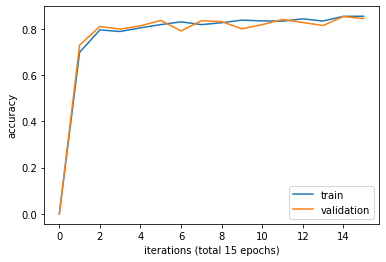


--------------------------------
Evaluating model (Shallow-FullyConnected)

48/48
accuracy: 0.875

Total Time taken: 238.72s
saving the model's metrics
#########################################

Fitting model (Deep-FullyConnected)

Epoch 1
t: 145/145
v: 48/48
Loss: 1.040 - accuracy: 0.355 - val_loss: 1.051 - val_accuracy: 0.349
*CB_ES* Loss didn't change much from last 2 epochs
*CB_ES* Percent change in loss value: 0.5129401572048664
Early Stopping at epoch= 1/15
Total Time taken: 80.70s


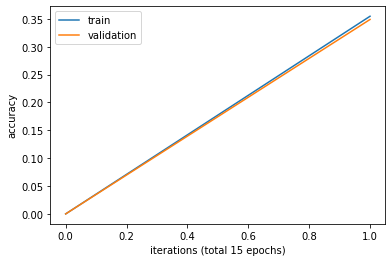


--------------------------------
Evaluating model (Deep-FullyConnected)

48/48
accuracy: 0.611

Total Time taken: 12.32s
saving the model's metrics
#########################################

Fitting model (Shallow-CNN)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.560 - accuracy: 0.609 - val_loss: 0.605 - val_accuracy: 0.697
Total Time taken: 87.19s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.572 - accuracy: 0.724 - val_loss: 0.571 - val_accuracy: 0.779
Total Time taken: 81.68s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.515 - accuracy: 0.762 - val_loss: 0.337 - val_accuracy: 0.822
Total Time taken: 81.31s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.526 - accuracy: 0.803 - val_loss: 0.253 - val_accuracy: 0.824
Total Time taken: 80.69s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.520 - accuracy: 0.806 - val_loss: 0.405 - val_accuracy: 0.792
Total Time taken: 80.77s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.440 - accuracy: 0.808 - val_loss: 0.416 - val_accuracy: 0.841
Total Time taken: 81.10s

Epoch 7
t: 145/145
v: 48/48
Loss: 0

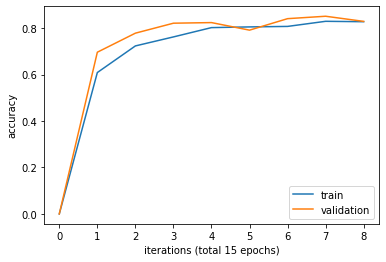


--------------------------------
Evaluating model (Shallow-CNN)

48/48
accuracy: 0.684

Total Time taken: 12.22s
saving the model's metrics
#########################################

Fitting model (Deep-CNN)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.385 - accuracy: 0.769 - val_loss: 0.977 - val_accuracy: 0.309
Total Time taken: 84.30s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.279 - accuracy: 0.872 - val_loss: 0.987 - val_accuracy: 0.316
Total Time taken: 82.99s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.318 - accuracy: 0.888 - val_loss: 0.372 - val_accuracy: 0.536
Total Time taken: 82.90s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.521 - accuracy: 0.894 - val_loss: 0.115 - val_accuracy: 0.826
Total Time taken: 82.57s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.219 - accuracy: 0.905 - val_loss: 0.135 - val_accuracy: 0.923
Total Time taken: 82.85s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.241 - accuracy: 0.904 - val_loss: 0.043 - val_accuracy: 0.910
Total Time taken: 83.33s

Epoch 7
t: 145/145
v: 48/48
Loss: 0.242 - accu

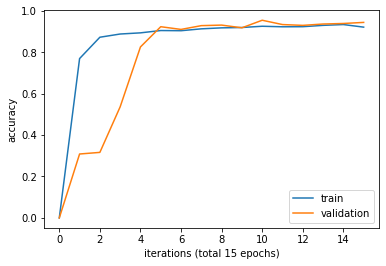


--------------------------------
Evaluating model (Deep-CNN)

48/48
accuracy: 0.744

Total Time taken: 12.45s
saving the model's metrics
#########################################

Fitting model (resnet18)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.594 - accuracy: 0.799 - val_loss: 1.843 - val_accuracy: 0.418
Total Time taken: 95.81s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.360 - accuracy: 0.895 - val_loss: 0.255 - val_accuracy: 0.671
Total Time taken: 93.66s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.404 - accuracy: 0.902 - val_loss: 0.060 - val_accuracy: 0.901
Total Time taken: 93.20s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.172 - accuracy: 0.913 - val_loss: 0.060 - val_accuracy: 0.928
Total Time taken: 93.02s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.344 - accuracy: 0.917 - val_loss: 0.034 - val_accuracy: 0.923
Total Time taken: 93.62s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.255 - accuracy: 0.926 - val_loss: 0.039 - val_accuracy: 0.947
Total Time taken: 93.31s

Epoch 7
t: 145/145
v: 48/48
Loss: 0.236 - accurac

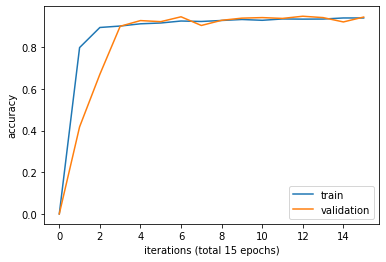


--------------------------------
Evaluating model (resnet18)

48/48
accuracy: 0.776

Total Time taken: 12.68s
saving the model's metrics
#########################################

Fitting model (resnet18_pretrained)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.179 - accuracy: 0.889 - val_loss: 0.993 - val_accuracy: 0.258
Total Time taken: 94.10s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.082 - accuracy: 0.945 - val_loss: 0.980 - val_accuracy: 0.309
Total Time taken: 92.05s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.044 - accuracy: 0.967 - val_loss: 1.082 - val_accuracy: 0.309
Total Time taken: 92.50s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.088 - accuracy: 0.965 - val_loss: 0.638 - val_accuracy: 0.453
Total Time taken: 92.12s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.154 - accuracy: 0.967 - val_loss: 0.491 - val_accuracy: 0.638
Total Time taken: 92.13s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.059 - accuracy: 0.972 - val_loss: 0.143 - val_accuracy: 0.862
Total Time taken: 92.32s

Epoch 7
t: 145/145
v: 48/48
Loss: 0.01

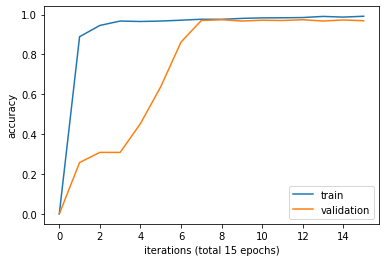


--------------------------------
Evaluating model (resnet18_pretrained)

48/48
accuracy: 0.806

Total Time taken: 12.70s
saving the model's metrics
#########################################

Fitting model (resnet50)

Epoch 1
t: 145/145
v: 48/48
Loss: 1.061 - accuracy: 0.574 - val_loss: 1.886 - val_accuracy: 0.346
Total Time taken: 118.65s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.458 - accuracy: 0.744 - val_loss: 2.764 - val_accuracy: 0.349
Total Time taken: 112.09s

Epoch 3
t: 145/145
v: 48/48
Loss: 1.119 - accuracy: 0.772 - val_loss: 1.867 - val_accuracy: 0.370
Total Time taken: 112.04s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.492 - accuracy: 0.796 - val_loss: 1.060 - val_accuracy: 0.482
Total Time taken: 112.32s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.224 - accuracy: 0.799 - val_loss: 0.360 - val_accuracy: 0.836
Total Time taken: 112.25s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.584 - accuracy: 0.823 - val_loss: 0.727 - val_accuracy: 0.866
Total Time taken: 111.99s

Epoch 7
t: 145/145
v: 48/48
Loss

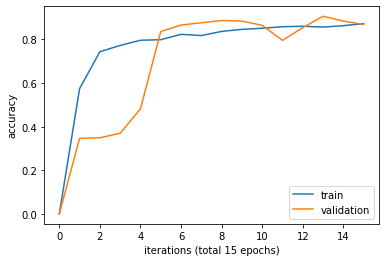


--------------------------------
Evaluating model (resnet50)

48/48
accuracy: 0.812

Total Time taken: 13.42s
saving the model's metrics
#########################################

Fitting model (resnet50_pretrained)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.514 - accuracy: 0.848 - val_loss: 2.531 - val_accuracy: 0.309
Total Time taken: 117.34s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.030 - accuracy: 0.929 - val_loss: 3.228 - val_accuracy: 0.309
Total Time taken: 112.07s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.071 - accuracy: 0.950 - val_loss: 3.006 - val_accuracy: 0.309
Total Time taken: 112.35s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.220 - accuracy: 0.953 - val_loss: 2.578 - val_accuracy: 0.309
Total Time taken: 112.02s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.065 - accuracy: 0.958 - val_loss: 1.688 - val_accuracy: 0.310
Total Time taken: 112.51s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.046 - accuracy: 0.958 - val_loss: 0.648 - val_accuracy: 0.340
Total Time taken: 111.89s

Epoch 7
t: 145/145
v: 48/48
Loss

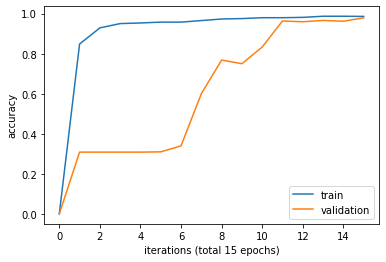


--------------------------------
Evaluating model (resnet50_pretrained)

48/48
accuracy: 0.827

Total Time taken: 13.29s
saving the model's metrics
#########################################

Fitting model (densenet121)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.456 - accuracy: 0.749 - val_loss: 2.282 - val_accuracy: 0.345
Total Time taken: 126.46s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.337 - accuracy: 0.836 - val_loss: 2.526 - val_accuracy: 0.346
Total Time taken: 114.18s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.310 - accuracy: 0.864 - val_loss: 1.359 - val_accuracy: 0.435
Total Time taken: 113.94s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.281 - accuracy: 0.869 - val_loss: 1.229 - val_accuracy: 0.581
Total Time taken: 114.55s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.107 - accuracy: 0.879 - val_loss: 0.515 - val_accuracy: 0.836
Total Time taken: 114.18s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.344 - accuracy: 0.899 - val_loss: 0.152 - val_accuracy: 0.927
Total Time taken: 114.40s

Epoch 7
t: 145/145
v: 48/48
L

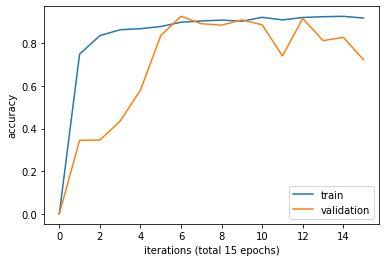


--------------------------------
Evaluating model (densenet121)

48/48
accuracy: 0.812

Total Time taken: 14.19s
saving the model's metrics
#########################################

Fitting model (densenet121_pretrained)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.673 - accuracy: 0.779 - val_loss: 1.094 - val_accuracy: 0.526
Total Time taken: 124.45s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.088 - accuracy: 0.903 - val_loss: 0.139 - val_accuracy: 0.897
Total Time taken: 114.35s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.171 - accuracy: 0.913 - val_loss: 0.069 - val_accuracy: 0.940
Total Time taken: 113.95s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.428 - accuracy: 0.928 - val_loss: 0.014 - val_accuracy: 0.964
Total Time taken: 114.26s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.493 - accuracy: 0.934 - val_loss: 0.037 - val_accuracy: 0.957
Total Time taken: 114.45s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.172 - accuracy: 0.934 - val_loss: 0.007 - val_accuracy: 0.952
Total Time taken: 113.96s

Epoch 7
t: 145/145
v: 48/4

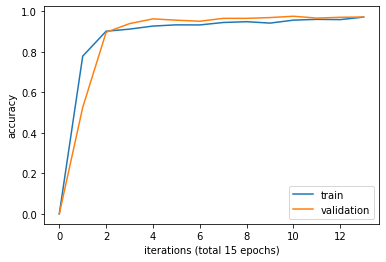


--------------------------------
Evaluating model (densenet121_pretrained)

48/48
accuracy: 0.826

Total Time taken: 14.16s
saving the model's metrics
#########################################

Fitting model (InceptionV3)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.570 - accuracy: 0.689 - val_loss: 1.142 - val_accuracy: 0.352
Total Time taken: 112.86s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.325 - accuracy: 0.825 - val_loss: 1.935 - val_accuracy: 0.310
Total Time taken: 104.46s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.697 - accuracy: 0.846 - val_loss: 1.214 - val_accuracy: 0.461
Total Time taken: 104.98s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.461 - accuracy: 0.848 - val_loss: 0.204 - val_accuracy: 0.612
Total Time taken: 105.04s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.364 - accuracy: 0.867 - val_loss: 0.038 - val_accuracy: 0.909
Total Time taken: 104.61s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.405 - accuracy: 0.872 - val_loss: 0.018 - val_accuracy: 0.910
Total Time taken: 104.33s

Epoch 7
t: 145/145
v: 48/4

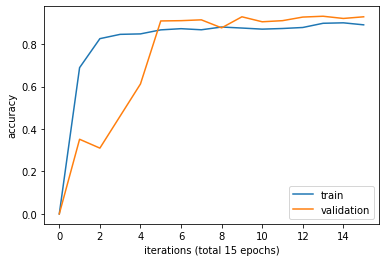


--------------------------------
Evaluating model (InceptionV3)

48/48
accuracy: 0.830

Total Time taken: 13.63s
saving the model's metrics
#########################################

Fitting model (InceptionV3_pretrained)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.253 - accuracy: 0.812 - val_loss: 0.464 - val_accuracy: 0.772
Total Time taken: 110.85s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.045 - accuracy: 0.923 - val_loss: 0.260 - val_accuracy: 0.806
Total Time taken: 104.34s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.176 - accuracy: 0.923 - val_loss: 0.130 - val_accuracy: 0.895
Total Time taken: 104.20s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.097 - accuracy: 0.945 - val_loss: 0.015 - val_accuracy: 0.941
Total Time taken: 104.14s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.039 - accuracy: 0.949 - val_loss: 0.051 - val_accuracy: 0.962
Total Time taken: 104.05s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.033 - accuracy: 0.950 - val_loss: 0.005 - val_accuracy: 0.962
Total Time taken: 104.19s

Epoch 7
t: 145/145
v: 48/4

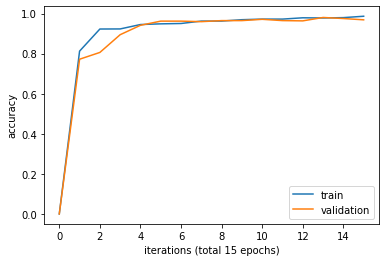


--------------------------------
Evaluating model (InceptionV3_pretrained)

48/48
accuracy: 0.840

Total Time taken: 13.77s
saving the model's metrics
#########################################

Fitting model (U_net)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.322 - accuracy: 0.798 - val_loss: 0.993 - val_accuracy: 0.699
Total Time taken: 100.18s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.350 - accuracy: 0.878 - val_loss: 0.863 - val_accuracy: 0.643
*CB_ES* Loss didn't change much from last 2 epochs
*CB_ES* Percent change in loss value: 0.09867250919342041
Early Stopping at epoch= 2/15
Total Time taken: 97.02s


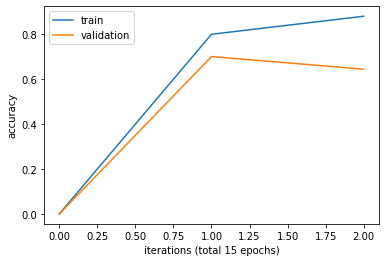


--------------------------------
Evaluating model (U_net)

48/48
accuracy: 0.824

Total Time taken: 13.05s
saving the model's metrics
#########################################


In [ ]:
# Using 60 20 20 split

df = pd.DataFrame(columns=['name', 'train_acc', 'val_acc', 'test_acc', 'recall', 'precision', 'f1_score'])
# df = pd.read_csv("model_comparison.csv")

for i, model in enumerate(models):
    trained_model, train_acc, val_acc, recall, precision, f1score = model_fit(model,
                                                                              train_generator,
                                                                              val_generator=val_generator,
                                                                              epochs=epochs,
                                                                              draw_graph=True,
                                                                              call_back=True)

    test_acc = model_evaluate(trained_model, test_generator)

    # adding a row
    params = {
        'name':model.name,
        'train_acc':train_acc.numpy(),
        'val_acc':val_acc.numpy(),
        'test_acc':test_acc.numpy(),
        'recall':recall.numpy(),
        'precision':precision.numpy(),
        'f1_score':f1score.numpy()
    }
    df = df.append(params, ignore_index=True)

    print("saving the model's metrics")
    train_models[model.name] = trained_model
    df.to_csv("./model_comparison.csv", index=False)
    print("#########################################")


## Finding our best model

We will start by loading our models' results.

In [ ]:
models_df = pd.read_csv("./model_comparison.csv")
models_train_dev = models_df.iloc[:,:3]
models_train_dev

,name,train_acc,val_acc
0,Shallow-FullyConnected,0.853879,0.843750
1,Deep-FullyConnected,0.354741,0.348958
2,Shallow-CNN,0.828017,0.829427
3,Deep-CNN,0.921121,0.944010
4,resnet18,0.940948,0.945312
5,resnet18_pretrained,0.991379,0.968750
6,resnet50,0.872414,0.868490
7,resnet50_pretrained,0.986207,0.979167
8,densenet121,0.918534,0.722656
9,densenet121_pretrained,0.972414,0.972656


In [ ]:
models_train_dev.drop(1).mean()

train_acc    0.920043
val_acc      0.884549
dtype: float64

We can see that, by comparing our train and validation accuracies <br>
models have high variance (overfit) (% > 3%):
- densenet121
- U_net

models have high bias (underfit) (% < 92%):
- Shallow-FullyConnected
- Deep-FullyConnected
- Shallow-CNN
- resnet50
- densenet121
- InceptionV3
- U_net

models with low bias and low varianve (candidate models):
- Deep-CNN (94.4%) 
- resnet18 (94.5%)            
- resnet18_pretrained (96.9%)
- InceptionV3_pretrained (96.9%)
- densenet121_pretrained (97.3%)
- resnet50_pretrained (97.9%)

In [ ]:
candidate_models = models_df.iloc[[3, 4, 5, 11, 9, 7]]
candidate_models.iloc[:,:3]

,name,train_acc,val_acc
3,Deep-CNN,0.921121,0.944010
4,resnet18,0.940948,0.945312
5,resnet18_pretrained,0.991379,0.968750
11,InceptionV3_pretrained,0.986638,0.968750
9,densenet121_pretrained,0.972414,0.972656
7,resnet50_pretrained,0.986207,0.979167


After finding our good candidate models, we will then use our recall score to pick the best model for our problem.
**Recall** is used in this case since we want to minimize the false-negatives as much as possible (we don't want someone with covid or pneumonia to go back home thinking there is no danger on his health) ,this will lead to us getting more false-postives, but almost all of our covid and pneumonia patients will be identified.

In [ ]:
# sort to find the best recall score
candidate_models.sort_values(by=["recall"], ascending=False).iloc[:,[0,4]]

,name,recall
5,resnet18_pretrained,0.990948
11,InceptionV3_pretrained,0.986638
7,resnet50_pretrained,0.985345
9,densenet121_pretrained,0.970259
4,resnet18,0.937500
3,Deep-CNN,0.916810


If we want to use the f1_score (which is the harmonic mean of precision and recall) this classifier will have a similar precision and recall.

In [ ]:
candidate_models.sort_values(by=["f1_score"], ascending=False).iloc[:,[0,6]]

,name,f1_score
5,resnet18_pretrained,0.991377
11,InceptionV3_pretrained,0.986646
7,resnet50_pretrained,0.986212
9,densenet121_pretrained,0.972422
4,resnet18,0.940950
3,Deep-CNN,0.921065


In [ ]:
candidate_models = candidate_models.sort_values(by=["recall"], ascending=False).iloc[:3,:]
candidate_models

,name,train_acc,val_acc,test_acc,recall,precision,f1_score
5,resnet18_pretrained,0.991379,0.968750,0.806424,0.990948,0.991803,0.991377
11,InceptionV3_pretrained,0.986638,0.968750,0.840278,0.986638,0.988342,0.986646
7,resnet50_pretrained,0.986207,0.979167,0.826986,0.985345,0.986195,0.986212


Both recall score and f1 score give out the same order, we will limit ourselves to the top 3 models, now we can proceed to find out how our models evaluate to on the test set.

In [ ]:
candidate_models.sort_values(by=["test_acc"], ascending=False).iloc[:,[0, 1, 3, 4]]

,name,train_acc,test_acc,recall
11,InceptionV3_pretrained,0.986638,0.840278,0.986638
7,resnet50_pretrained,0.986207,0.826986,0.985345
5,resnet18_pretrained,0.991379,0.806424,0.990948


**InceptionV3_pretrained** seems like the best overall model between our candidates, they are all close in their train and recall scores, but it has the highest test_acc.

## Saving our model

we can now save our final model using the code below.

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
inception_v3_pretrained.save('InceptionV3_15epochs_60split.h5')

## Fine-tune our final model

Our final model was overfitting on our test set but not as much on our validation set, and we are unable to get more data (we can use reguralization methods to reduce the overfitting), we will train our model with more epochs to see if there is any change to our accuracies (make sure there is no avoidable bias).

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
my_model = tf.keras.models.load_model('inceptionV3.h5')


Fitting model (InceptionV3_pretrained)

Epoch 1
t: 145/145
v: 48/48
Loss: 0.144 - accuracy: 0.979 - val_loss: 0.014 - val_accuracy: 0.967
Total Time taken: 104.07s

Epoch 2
t: 145/145
v: 48/48
Loss: 0.003 - accuracy: 0.981 - val_loss: 0.002 - val_accuracy: 0.966
Total Time taken: 96.62s

Epoch 3
t: 145/145
v: 48/48
Loss: 0.041 - accuracy: 0.985 - val_loss: 0.002 - val_accuracy: 0.967
Total Time taken: 96.69s

Epoch 4
t: 145/145
v: 48/48
Loss: 0.038 - accuracy: 0.986 - val_loss: 0.001 - val_accuracy: 0.965
Total Time taken: 96.41s

Epoch 5
t: 145/145
v: 48/48
Loss: 0.107 - accuracy: 0.989 - val_loss: 0.006 - val_accuracy: 0.966
Total Time taken: 96.63s

Epoch 6
t: 145/145
v: 48/48
Loss: 0.001 - accuracy: 0.990 - val_loss: 0.000 - val_accuracy: 0.967
Total Time taken: 96.67s

Epoch 7
t: 145/145
v: 48/48
Loss: 0.006 - accuracy: 0.996 - val_loss: 0.001 - val_accuracy: 0.973
Total Time taken: 96.61s

Epoch 8
t: 145/145
v: 48/48
Loss: 0.001 - accuracy: 0.996 - val_loss: 0.002 - val_accuracy

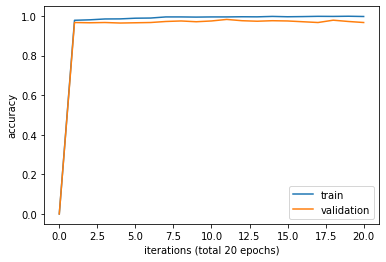


--------------------------------
Evaluating model (InceptionV3_pretrained)

48/48
accuracy: 0.951

Total Time taken: 13.30s
#########################################


In [ ]:
epochs = 20
df = pd.DataFrame(columns=['name', 'train_acc', 'val_acc', 'test_acc', 'recall', 'precision', 'f1_score'])


trained_model, train_acc, val_acc, recall, precision, f1score = model_fit(my_model,                                                                   
                                                                            train_generator,
                                                                            val_generator=val_generator,
                                                                            epochs=epochs,
                                                                            draw_graph=True,
                                                                            call_back=True)

test_acc = model_evaluate(my_model, test_generator)


params = {
    'name':my_model.name,
    'train_acc':train_acc.numpy(),
    'val_acc':val_acc.numpy(),
    'test_acc':test_acc.numpy(),
    'recall':recall.numpy(),
    'precision':precision.numpy(),
    'f1_score':f1score.numpy()
}
df = df.append(params, ignore_index=True)

df.to_csv("./InceptionV3_35epochs_60split_score.csv", index=False)
print("#########################################")

Our model's val_accuracy is fluctuating due to the small size of our validation set which might result in overfitting.

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
my_model.save('InceptionV3_35epochs_60split.h5')

We can see that our model's test accuracy improved after training it on 20 more epochs (initial 15 + retrain on 20 = total 35 epochs). It went from 84% to 95%. the model is still slightly overfitting (have high variance) but we reached a great test accuracy so we can stop here.

In [ ]:
df2 = df.append(candidate_models.iloc[1], ignore_index=True)

In [ ]:
df2.iloc[0,0]="InceptionV3_@35epochs"
df2.iloc[1,0]="InceptionV3_@15epochs"

In [ ]:
df2

,name,train_acc,val_acc,test_acc,recall,precision,f1_score
0,InceptionV3_@35epochs,0.997845,0.967448,0.950521,0.997845,0.997845,0.997845
11,InceptionV3_@15epochs,0.986638,0.968750,0.840278,0.986638,0.988342,0.986646


In [ ]:
df2.to_csv("./InceptionV3_15epochs_35epochs.csv", index=False)
print("#########################################")

#########################################


## Trying other Train/Test splits

In [ ]:
## testing another split, 80% 10% 10%

test_size = 0.1
val_size = 0.111

train2, test2 = train_test_split(data_df, test_size=test_size, random_state=42, stratify=data_df["diagnosis"])
train2, val2 = train_test_split(train2, test_size=val_size, random_state=42, stratify=train2["diagnosis"])
print("train images count: {} ({:.1f}%)".format(train2.shape[0], (train2.shape[0]/data_size)*100))
print("validation images count: {} ({:.1f}%)".format(val2.shape[0], (val2.shape[0]/data_size)*100))
print("test images count: {} ({:.1f}%)".format(test2.shape[0], (test2.shape[0]/data_size)*100))

train images count: 3108 (80.0%)
validation images count: 389 (10.0%)
test images count: 389 (10.0%)


In [ ]:
## for 80 10 10 split
train_generator2 = DataGenerator(train2["dir"].tolist(), train2["diagnosis_cat"].tolist())
val_generator2 = DataGenerator(val2["dir"].tolist(), val2["diagnosis_cat"].tolist())
test_generator2 = DataGenerator(test2["dir"].tolist(), test2["diagnosis_cat"].tolist(),train=False)


Fitting model (InceptionV3_pretrained)

Epoch 1
t: 194/194
v: 24/24
Loss: 0.051 - accuracy: 0.798 - val_loss: 0.334 - val_accuracy: 0.844
Total Time taken: 127.36s

Epoch 2
t: 194/194
v: 24/24
Loss: 0.041 - accuracy: 0.916 - val_loss: 0.092 - val_accuracy: 0.904
Total Time taken: 112.40s

Epoch 3
t: 194/194
v: 24/24
Loss: 0.087 - accuracy: 0.932 - val_loss: 0.028 - val_accuracy: 0.935
Total Time taken: 112.01s

Epoch 4
t: 194/194
v: 24/24
Loss: 0.074 - accuracy: 0.941 - val_loss: 0.022 - val_accuracy: 0.969
Total Time taken: 112.03s

Epoch 5
t: 194/194
v: 24/24
Loss: 0.098 - accuracy: 0.953 - val_loss: 0.025 - val_accuracy: 0.964
Total Time taken: 111.75s

Epoch 6
t: 194/194
v: 24/24
Loss: 0.031 - accuracy: 0.957 - val_loss: 0.009 - val_accuracy: 0.961
Total Time taken: 111.53s

Epoch 7
t: 194/194
v: 24/24
Loss: 0.036 - accuracy: 0.959 - val_loss: 0.014 - val_accuracy: 0.961
Total Time taken: 111.58s

Epoch 8
t: 194/194
v: 24/24
Loss: 0.011 - accuracy: 0.961 - val_loss: 0.003 - val_ac

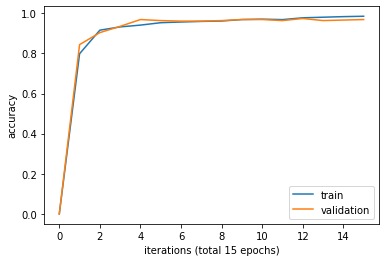


--------------------------------
Evaluating model (InceptionV3_pretrained)

24/24
accuracy: 0.953

Total Time taken: 8.31s
#########################################


In [ ]:
epochs = 15

# creating our new model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(n_classes, activation= 'softmax')(x)
my_model = keras.models.Model(inputs = base_model.input, outputs = predictions, name="InceptionV3_pretrained")


# Train/Validate
trained_model, train_acc, val_acc, recall, precision, f1score = model_fit(my_model,                                                                   
                                                                            train_generator2,
                                                                            val_generator=val_generator2,
                                                                            epochs=epochs,
                                                                            draw_graph=True,
                                                                            call_back=True)
# Evaluate
test_acc = model_evaluate(my_model, test_generator2)


params = {
    'name':my_model.name,
    'train_acc':train_acc.numpy(),
    'val_acc':val_acc.numpy(),
    'test_acc':test_acc.numpy(),
    'recall':recall.numpy(),
    'precision':precision.numpy(),
    'f1_score':f1score.numpy()
}

df3 = df2.append(params, ignore_index=True)
df3.iloc[2,0]="InceptionV3_@15epochs_@80split"

df3.to_csv("./InceptionV3_60split_80split.csv", index=False)
print("#########################################")

In [ ]:
df3

,name,train_acc,val_acc,test_acc,recall,precision,f1_score
0,InceptionV3_@35epochs,0.997845,0.967448,0.950521,0.997845,0.997845,0.997845
1,InceptionV3_@15epochs,0.986638,0.968750,0.840278,0.986638,0.988342,0.986646
2,InceptionV3_@15epochs_@80split,0.985180,0.968750,0.953125,0.985180,0.985816,0.985183


In [ ]:
my_model.save('InceptionV3_15epochs_80split.h5')

It appears that our model does alot better on a (80, 10, 10) split rather than the (60, 20, 20) after 15 epochs, and it is not overfitting as much, but it have a slightly lower recall as well. 
Finally we can check if after we also give it 20 more epochs, if it will have better test accuracy.

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
my_model = tf.keras.models.load_model('InceptionV3_15epochs_80split.h5')


Fitting model (InceptionV3_pretrained)

Epoch 1
t: 194/194
v: 24/24
Loss: 0.083 - accuracy: 0.971 - val_loss: 0.234 - val_accuracy: 0.971
Total Time taken: 1001.04s

Epoch 2
t: 194/194
v: 24/24
Loss: 0.021 - accuracy: 0.971 - val_loss: 0.080 - val_accuracy: 0.969
Total Time taken: 112.32s

Epoch 3
t: 194/194
v: 24/24
Loss: 0.045 - accuracy: 0.976 - val_loss: 0.158 - val_accuracy: 0.977
Total Time taken: 112.37s

Epoch 4
t: 194/194
v: 24/24
Loss: 0.024 - accuracy: 0.983 - val_loss: 0.113 - val_accuracy: 0.971
Total Time taken: 111.90s

Epoch 5
t: 194/194
v: 24/24
Loss: 0.040 - accuracy: 0.982 - val_loss: 0.203 - val_accuracy: 0.966
Total Time taken: 112.27s

Epoch 6
t: 194/194
v: 24/24
Loss: 0.136 - accuracy: 0.986 - val_loss: 0.010 - val_accuracy: 0.966
Total Time taken: 112.14s

Epoch 7
t: 194/194
v: 24/24
Loss: 0.008 - accuracy: 0.987 - val_loss: 0.048 - val_accuracy: 0.974
Total Time taken: 112.00s

Epoch 8
t: 194/194
v: 24/24
Loss: 0.024 - accuracy: 0.986 - val_loss: 0.299 - val_a

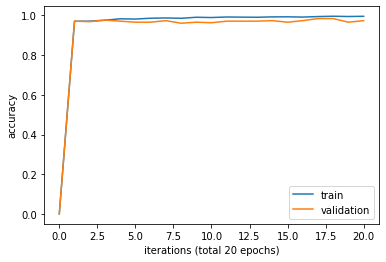


--------------------------------
Evaluating model (InceptionV3_pretrained)

24/24
accuracy: 0.964

Total Time taken: 93.55s


In [ ]:
epochs = 20

trained_model, train_acc, val_acc, recall, precision, f1score = model_fit(my_model,                                                                   
                                                                            train_generator2,
                                                                            val_generator=val_generator2,
                                                                            epochs=epochs,
                                                                            draw_graph=True,
                                                                            call_back=True)

test_acc = model_evaluate(my_model, test_generator2)

params = {
    'name':"InceptionV3_@35epochs_@80split",
    'train_acc':train_acc.numpy(),
    'val_acc':val_acc.numpy(),
    'test_acc':test_acc.numpy(),
    'recall':recall.numpy(),
    'precision':precision.numpy(),
    'f1_score':f1score.numpy()
}


In [ ]:
my_model.save('InceptionV3_35epochs_80split.h5')

In [ ]:
df = pd.read_csv("./InceptionV3_60split_80split.csv")

df.loc[0.5] = pd.Series(params)
df = df.sort_index().reset_index(drop=True)

df.to_csv("./compare_epochs&splits.csv", index=False)
print("#########################################")

#########################################


In [ ]:
df

,name,train_acc,val_acc,test_acc,recall,precision,f1_score
0,InceptionV3_@35epochs,0.997845,0.967448,0.950521,0.997845,0.997845,0.997845
1,InceptionV3_@35epochs_@80split,0.995812,0.973958,0.963542,0.995812,0.995812,0.995811
2,InceptionV3_@15epochs,0.986638,0.968750,0.840278,0.986638,0.988342,0.986646
3,InceptionV3_@15epochs_@80split,0.985180,0.968750,0.953125,0.985180,0.985816,0.985183


Even after adding 20 more epochs, our 80 split model has higher test accuracy (1.3%) and less variance (4.7% > 3.2%) than our 60 split model, but still have a really slight difference in recall score (0.2%).